In [1]:
import shutil

import matplotlib.pyplot as plt
import pandas as pd

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.regularizers import l1_l2
from tensorflow import keras
import tensorflow as tf
from tqdm import tqdm
import warnings
import os

from functions import *

pd.set_option('display.float_format', '{:.6f}'.format)

2023-09-29 16:55:11.488134: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-29 16:55:12.165351: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Data

In [2]:
df = pd.read_csv(df_path, index_col="Unnamed: 0").T

In [3]:
print(df)

              1050608  130468   3589405  355102   1081058  189592   354275   \
E000823.1.8         0        0        0        0        0        0        0   
E000823.2.6         0        0        0        0        0        0        0   
E000823.4.0         0        0        0        0        0        0        0   
E000823.5.0         0        0        0        0        0        0        0   
E000823.5.7         0        0        0        0        0        0        0   
...               ...      ...      ...      ...      ...      ...      ...   
E014086.30.4        0        0        0        0        0        1       11   
E014086.32.4        0        0        0        0        0        0       13   
E014086.33.5        0        0        0        0        0        0        0   
E014086.34.4        0        0        0        0        0        1        0   
E014086.36.0        0        0        0        0        0        0        0   

              4327628  326749   183857   ...  31792

## Preprocessing


In [4]:
zero_values_percentage_cutoff = 0.5 # no more than x% of data can be zeros
smoothing_window_size = 5
df = preprocess(zero_values_percentage_cutoff=zero_values_percentage_cutoff, smoothing_window_size=smoothing_window_size)

2023-09-29 16:55:23.881587: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-29 16:55:23.900346: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-29 16:55:23.905047: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-29 16:55:23.922528: I tensorflow/core/platform/cpu_featu

In [5]:
df

,659361,364179,3439402,181155,302746,4473763,175535,3887769,585227,189384,...,359650,130663,922761,3304236,584137,193233,4334711,196664,583117,354850
E000823.1.8,0.000000,0.000221,0.195402,0.002871,0.000000,0.252560,0.009901,0.145455,0.000000,0.087963,...,0.000000,0.237179,0.000433,0.102041,0.000000,0.042448,0.507874,0.063005,0.010525,0.043189
E000823.2.6,0.052888,0.000273,0.137931,0.012440,0.000000,0.204778,0.007921,0.109091,0.000000,0.120370,...,0.000000,0.173077,0.000939,0.163265,0.000067,0.037373,0.437008,0.056729,0.010298,0.019934
E000823.4.0,0.052888,0.000256,0.160920,0.013397,0.000000,0.443686,0.019802,0.072727,0.000000,0.074074,...,0.000000,0.179487,0.000987,0.183673,0.000067,0.053983,0.389764,0.069040,0.032819,0.013289
E000823.5.0,0.052888,0.000204,0.103448,0.053589,0.000000,0.375427,0.019802,0.054545,0.000000,0.064815,...,0.000000,0.166667,0.003901,0.183673,0.000089,0.048139,0.338583,0.052505,0.030623,0.000000
E000823.5.7,0.052888,0.000204,0.195402,0.053589,0.046985,0.382253,0.021782,0.054545,0.112668,0.078704,...,0.000000,0.147436,0.080911,0.122449,0.053025,0.044909,0.287402,0.054919,0.083269,0.013289
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E014086.22.5,0.054103,0.115345,0.172414,0.001435,0.058205,0.044369,0.033663,0.418182,0.361913,0.402778,...,0.339315,0.115385,0.000024,0.428571,0.045208,0.085205,0.177165,0.131201,0.328075,0.289037
E014086.23.4,0.084802,0.145123,0.183908,0.006699,0.062412,0.088737,0.035644,0.545455,0.462215,0.532407,...,0.428222,0.115385,0.000747,0.489796,0.061491,0.110889,0.212598,0.174412,0.407474,0.209302
E014086.24.5,0.094833,0.161664,0.379310,0.009091,0.105189,0.143345,0.067327,0.563636,0.874141,0.800926,...,0.644372,0.205128,0.000747,0.489796,0.084206,0.133959,0.283465,0.297284,0.596487,0.325581
E014086.26.4,0.059574,0.153453,0.597701,0.009091,0.183029,0.334471,0.071287,0.709091,0.932949,0.828704,...,0.712072,0.243590,0.000747,0.408163,0.071408,0.196555,0.334646,0.417139,0.741297,0.365449


## Features and targets

In [6]:
seq_length = 50
cutoff = 411

X_sequences, y_targets = cut_to_sequences(feats_df=df, seq_length=seq_length)

y_targets = pd.DataFrame(y_targets)
y_targets.columns = df.columns

X_sequences_train = X_sequences[:cutoff]
y_targets_train = y_targets[:cutoff]

X_sequences_test = X_sequences[cutoff:]
y_targets_test = y_targets[cutoff:]

print(f"Length of data: {len(df)}")
print(f"Total sequences: {len(X_sequences)}")
print(f"Train sequences: {len(X_sequences_train)}")
print(f"Test sequences: {len(X_sequences_test)}")

Length of data: 516
Total sequences: 466
Train sequences: 411
Test sequences: 55


In [7]:
y_targets

,659361,364179,3439402,181155,302746,4473763,175535,3887769,585227,189384,...,359650,130663,922761,3304236,584137,193233,4334711,196664,583117,354850
0,0.006383,0.000119,0.172414,0.003349,0.000000,0.105802,0.019802,0.181818,0.025556,0.129630,...,0.022838,0.160256,0.000241,0.346939,0.001832,0.037066,0.181102,0.036934,0.062740,0.305648
1,0.000304,0.000085,0.137931,0.004306,0.000000,0.109215,0.009901,0.218182,0.000000,0.120370,...,0.000000,0.160256,0.000265,0.326531,0.000045,0.031221,0.196850,0.035607,0.089471,0.212625
2,0.000304,0.000307,0.149425,0.007177,0.000000,0.116041,0.001980,0.272727,0.000000,0.148148,...,0.000000,0.141026,0.000241,0.326531,0.000022,0.025377,0.161417,0.028485,0.087275,0.212625
3,0.000304,0.000290,0.126437,0.007656,0.000000,0.095563,0.000000,0.181818,0.000000,0.134259,...,0.000000,0.076923,0.000265,0.265306,0.000022,0.014611,0.102362,0.018829,0.067131,0.209302
4,0.000304,0.000290,0.114943,0.018182,0.000000,0.116041,0.003960,0.181818,0.000000,0.111111,...,0.000000,0.089744,0.000843,0.244898,0.000000,0.016764,0.110236,0.025106,0.049771,0.199336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
461,0.054103,0.115345,0.172414,0.001435,0.058205,0.044369,0.033663,0.418182,0.361913,0.402778,...,0.339315,0.115385,0.000024,0.428571,0.045208,0.085205,0.177165,0.131201,0.328075,0.289037
462,0.084802,0.145123,0.183908,0.006699,0.062412,0.088737,0.035644,0.545455,0.462215,0.532407,...,0.428222,0.115385,0.000747,0.489796,0.061491,0.110889,0.212598,0.174412,0.407474,0.209302
463,0.094833,0.161664,0.379310,0.009091,0.105189,0.143345,0.067327,0.563636,0.874141,0.800926,...,0.644372,0.205128,0.000747,0.489796,0.084206,0.133959,0.283465,0.297284,0.596487,0.325581
464,0.059574,0.153453,0.597701,0.009091,0.183029,0.334471,0.071287,0.709091,0.932949,0.828704,...,0.712072,0.243590,0.000747,0.408163,0.071408,0.196555,0.334646,0.417139,0.741297,0.365449


## The model

In [8]:
import keras.backend as K

In [21]:
def fetch_model():

    reg = 1e-12
    
    n_feats = len(df.columns)
    
    model = Sequential()
    model.add(keras.Input(shape=(seq_length, n_feats)))
    model.add(keras.layers.LSTM(1024, return_sequences=False, activation='relu'))
    model.add(keras.layers.Dense(512, activation="tanh", kernel_regularizer=l1_l2(reg)))
    model.add(keras.layers.Dense(128, activation="elu", kernel_regularizer=l1_l2(reg)))
    model.add(keras.layers.Dense(64, activation="relu", kernel_regularizer=l1_l2(reg)))
    model.add(keras.layers.Dense(1, activation="relu"))
    
    model.compile(optimizer="Adam", loss=loss, metrics=["mae", "mape"])
    
    return model

In [22]:
def compile_model(model, loss):
    model.compile(optimizer="Adam", loss=loss, metrics=["mae", "mape"])
    return model

In [23]:
#model = fetch_model()
#
#model.summary()
#
#model.save("/home/nate/temp/test_model_save.model")

## Individual model testbench

In [24]:
import tensorflow as tf

class mae_ignore_zeros(tf.keras.losses.Loss):
    
    def __init__(self, false_positives_penalty_factor, name='mae_ignore_zeros', reduction=tf.keras.losses.Reduction.AUTO,):
        super(mae_ignore_zeros, self).__init__()
        self.false_positives_penalty_factor = false_positives_penalty_factor
        self.name = name
        

    def call(self, y_true, y_pred):
        
        y_true = tf.cast(y_true, tf.float64)
        y_pred = tf.cast(y_pred, tf.float64)
        
        false_positives_penalty_factor = tf.constant(self.false_positives_penalty_factor, dtype=tf.float64)
        
        # Find indices where y_true is not zero
        non_zero_indices = tf.where(tf.not_equal(y_true, 0))
      
        y_true = tf.reshape(y_true, (-1, 1))
        y_pred = tf.reshape(y_pred, (-1, 1))
        
        # Gather the non-zero elements from y_true and y_pred using the indices
        y_true_non_zero = tf.gather_nd(y_true, non_zero_indices)
        y_pred_non_zero = tf.gather_nd(y_pred, non_zero_indices)

        y_true_non_zero = tf.cast(y_true_non_zero, tf.float64)
        y_pred_non_zero = tf.cast(y_pred_non_zero, tf.float64)

        # Calculate MAE on the non-zero elements
        mae_non_zero = tf.reduce_mean(tf.abs(y_pred_non_zero - y_true_non_zero))

        # Find indices where y_true is zero
        zero_indices = tf.where(tf.equal(y_true, 0))

        # Gather the corresponding y_pred values
        y_pred_zero = tf.gather_nd(y_pred, zero_indices)

        y_pred_zero = tf.cast(y_pred_zero, tf.float64)

        # Calculate the average of false positives
        false_positives_avg = tf.reduce_mean(y_pred_zero)
        
        # Combine the MAE on non-zero elements with the average of false positives
        mae_ignore_zeros = mae_non_zero + (false_positives_avg * false_positives_penalty_factor)
    
        return mae_ignore_zeros


In [25]:
y_true = tf.constant([0])
y_pred = tf.constant([1])

loss = mae_ignore_zeros(false_positives_penalty_factor=0.3)
loss.call(y_true, y_pred)

<tf.Tensor: shape=(), dtype=float64, numpy=nan>

In [26]:
target_taxa = 585419

plot=False

if plot is True:
    plot_a_taxa_sequence(y_targets_train[target_taxa], title=f"Train sequence for taxa_idx {target_taxa}", color="blue")

In [27]:
n_epochs = 15

loss = mae_ignore_zeros(false_positives_penalty_factor=0.3)
model = fetch_model()
model = compile_model(model, loss)

model.fit(x=X_sequences_train, y=y_targets_train[target_taxa], validation_split=0.05, epochs=n_epochs, verbose=1)

Epoch 1/15
13/13 [==============================] - 3s 60ms/step - loss: nan - mae: 0.1038 - mape: 350.6119 - val_loss: nan - val_mae: 0.0473 - val_mape: 100.0000
Epoch 2/15
13/13 [==============================] - 1s 46ms/step - loss: nan - mae: 0.1034 - mape: 100.0000 - val_loss: nan - val_mae: 0.0473 - val_mape: 100.0000
Epoch 3/15
 1/13 [=>............................] - ETA: 0s - loss: nan - mae: 0.0752 - mape: 100.0000

Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x7efc2fe69cf0>
Traceback (most recent call last):
  File "/home/nate/anaconda3/envs/tu_medical/lib/python3.10/weakref.py", line 370, in remove
    def remove(k, selfref=ref(self)):
KeyboardInterrupt: 

KeyboardInterrupt



2/2 [==============================] - 0s 8ms/step


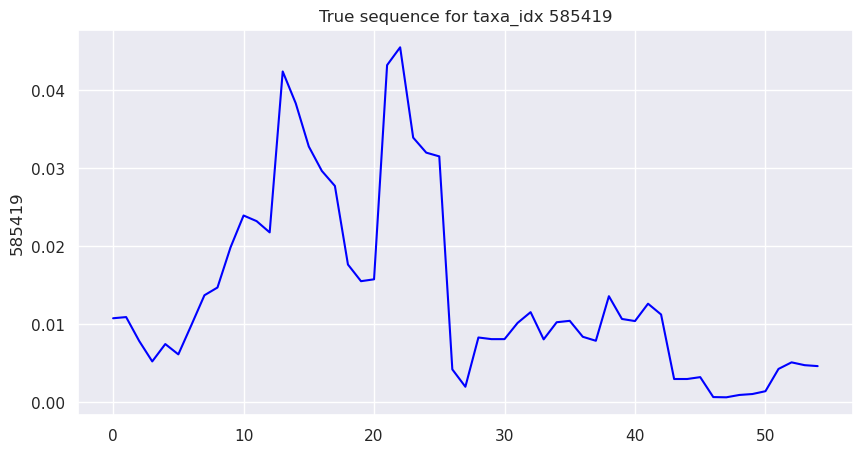

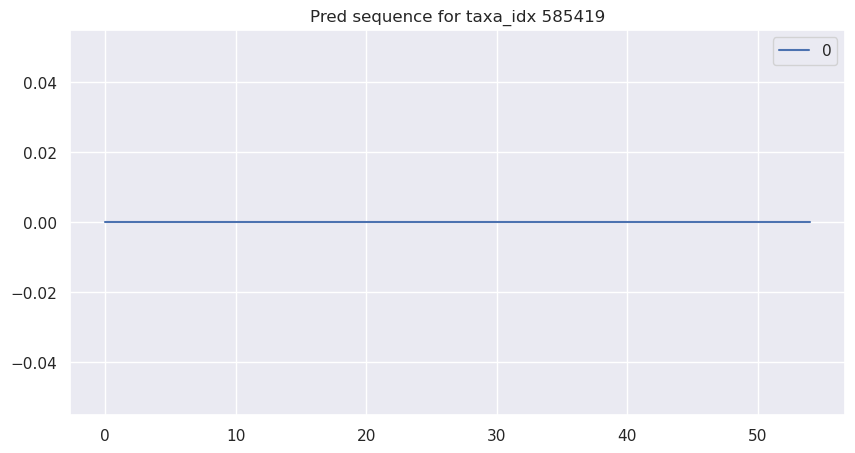

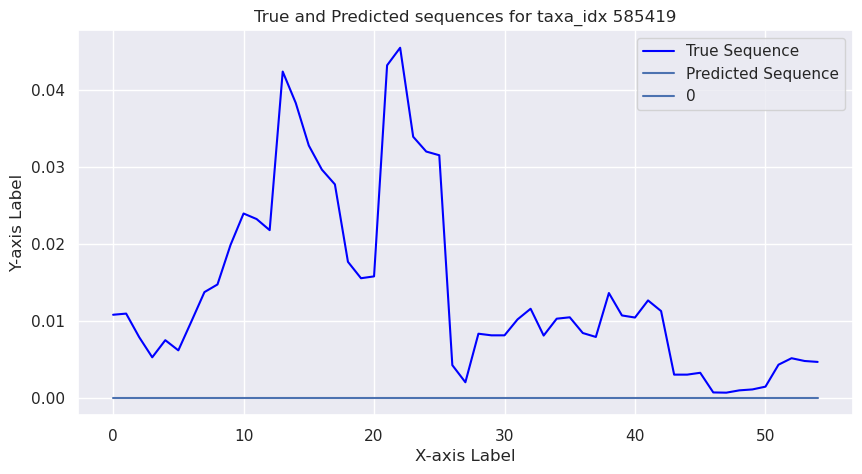

In [16]:
y_pred = model.predict(X_sequences_test)

true_sequence = y_targets_test[target_taxa].reset_index(drop=True)
pred_sequence = y_pred

sequence_comparisson_graphs(true_sequence, pred_sequence, target_taxa)

## The Ensemble

In [28]:
class ensemble():
    
    def __init__(self, ensemble_name, loss, overwrite_on_train=False):
        
        self.models_out_dir = f"{root_dir}/models/{ensemble_name}"
        self.overwrite_on_train = overwrite_on_train
        self.loss = loss

        
    def train(self, X_sequences_train, y_targets_train, n_epochs):
        
        if not os.path.exists(self.models_out_dir):
            os.mkdir(self.models_out_dir)
        else:
            if self.overwrite_on_train is False:
                raise Exception("This model dir already exists")
            else:
                print("Overwriting an existing model dir")
                shutil.rmtree(self.models_out_dir)
                os.mkdir(self.models_out_dir)
                
        for taxa_idx in tqdm(y_targets_train.columns, desc="Training models"):
            
            model = fetch_model()
            model = compile_model(model, loss)
            y_targets = y_targets_train[taxa_idx]
            model.fit(x=X_sequences_train, y=y_targets, validation_split=0.05, epochs=n_epochs, verbose=0)
            
            model.save(f"{self.models_out_dir}/{taxa_idx}.model")
            
            del model
            
    
    def load(self):
        
        self.model_dic = {}

        for model_dir in tqdm(os.listdir(self.models_out_dir), desc="Loading the models"):
            taxa_idx = int(model_dir.replace(".model", ""))
            
            if isinstance(loss, mae_ignore_zeros):
                model = tf.keras.models.load_model(f"{self.models_out_dir}/{taxa_idx}.model", compile=False)
                model = compile_model(model, loss)
            else:
                model = tf.keras.models.load_model(f"{self.models_out_dir}/{taxa_idx}.model")
                
            self.model_dic[taxa_idx] = model
    
         
    def predict(self, X_sequences):
        
        self.load()
        
        n_sequences = len(X_sequences)
        
        pred_list = []
        for taxa_idx in tqdm(self.model_dic.keys(), desc="Predicting values"):
            model = self.model_dic[taxa_idx]
            pred_list.append(model.predict(X_sequences, verbose=0).reshape(n_sequences,))
            del(model)
            
        pred_df = pd.DataFrame(pred_list).T
            
        return pred_df

In [29]:
# Tensorflow does not play nice with my Linux machine, thus I am filtering out its warnings
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

loss = mae_ignore_zeros(false_positives_penalty_factor=0.1)

model_ensemble = ensemble(ensemble_name="test_ensemble", loss=loss, overwrite_on_train=True)

In [30]:
model_ensemble.train(X_sequences_train=X_sequences_train, y_targets_train=y_targets_train, n_epochs=15)

Overwriting an existing model dir


Training models: 100%|██████████| 202/202 [44:36<00:00, 13.25s/it]


In [31]:
y_test_df = pd.DataFrame(y_targets_test)
y_test_df = y_test_df.reset_index(drop=True)
y_test_df

,659361,364179,3439402,181155,302746,4473763,175535,3887769,585227,189384,...,359650,130663,922761,3304236,584137,193233,4334711,196664,583117,354850
0,0.037386,0.013270,0.436782,0.017225,0.147265,0.109215,0.615842,0.254545,0.009343,0.046296,...,0.268352,0.153846,0.021143,0.163265,0.053025,0.587819,0.082677,0.266264,0.265606,0.302326
1,0.019149,0.012742,0.344828,0.014833,0.117812,0.054608,0.483168,0.254545,0.009343,0.046296,...,0.238989,0.083333,0.021143,0.163265,0.040316,0.453091,0.062992,0.202535,0.222715,0.235880
2,0.012158,0.014207,0.264368,0.014354,0.112202,0.058020,0.843564,0.254545,0.018137,0.101852,...,0.196574,0.070513,0.020396,0.142857,0.076992,0.786066,0.055118,0.393724,0.255036,0.481728
3,0.008207,0.010511,0.103448,0.008134,0.069425,0.040956,0.506931,0.072727,0.096455,0.074074,...,0.079119,0.032051,0.018687,0.061224,0.062362,0.582744,0.055118,0.300905,0.142139,0.385382
4,0.008207,0.004054,0.057471,0.006699,0.062412,0.037543,0.435644,0.018182,0.089860,0.078704,...,0.061990,0.032051,0.050690,0.040816,0.058386,0.470624,0.059055,0.257333,0.089946,0.338870
5,0.001520,0.004940,0.137931,0.003349,0.012623,0.098976,0.475248,0.000000,0.089035,0.078704,...,0.013051,0.121795,0.128928,0.040816,0.056085,0.616887,0.192913,0.305854,0.089652,0.335548
6,0.001520,0.007478,0.137931,0.006220,0.012623,0.109215,0.487129,0.000000,0.092883,0.078704,...,0.013051,0.134615,0.147687,0.040816,0.056085,0.653491,0.212598,0.324321,0.100833,0.335548
7,0.000608,0.006712,0.091954,0.008612,0.011921,0.112628,0.077228,0.000000,0.244573,0.013889,...,0.004894,0.179487,0.172972,0.020408,0.004221,0.257767,0.204724,0.107423,0.037753,0.049834
8,0.000000,0.006184,0.114943,0.008134,0.011921,0.129693,0.073267,0.000000,0.165155,0.004630,...,0.000816,0.185897,0.173140,0.000000,0.000424,0.246386,0.200787,0.107906,0.070708,0.003322
9,0.000000,0.006490,0.229885,0.016268,0.080645,0.133106,0.089109,0.000000,0.169827,0.000000,...,0.267537,0.160256,0.132155,0.000000,0.009225,0.261150,0.200787,0.126735,0.127246,0.000000


In [32]:
y_pred_df = model_ensemble.predict(X_sequences_test)
y_pred_df = y_pred_df.reset_index(drop=True)
y_pred_df.columns = y_test_df.columns

Predicting values: 100%|██████████| 202/202 [00:32<00:00,  6.18it/s]


In [33]:
y_pred_df

,659361,364179,3439402,181155,302746,4473763,175535,3887769,585227,189384,...,359650,130663,922761,3304236,584137,193233,4334711,196664,583117,354850
0,0.000000,0.000000,0.235594,0.000000,0.000000,0.000000,0.000000,0.000000,0.080601,0.273890,...,0.000000,0.000000,0.051245,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.240712,0.000000,0.000000,0.000000,0.000000,0.000000,0.115278,0.282780,...,0.000000,0.000000,0.051245,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.213735,0.000000,0.000000,0.000000,0.000000,0.000000,0.082516,0.266767,...,0.000000,0.000000,0.051245,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.206971,0.000000,0.000000,0.000000,0.000000,0.000000,0.106664,0.287122,...,0.000000,0.000000,0.051245,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.172268,0.000000,0.000000,0.000000,0.000000,0.000000,0.090416,0.238734,...,0.000000,0.000000,0.051245,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.148383,0.000000,0.000000,0.000000,0.000000,0.000000,0.066706,0.215749,...,0.000000,0.000000,0.051245,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.157911,0.000000,0.000000,0.000000,0.000000,0.000000,0.046399,0.205172,...,0.000000,0.000000,0.051245,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.174200,0.000000,0.000000,0.000000,0.000000,0.000000,0.122975,0.198582,...,0.000000,0.000000,0.051245,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.166769,0.000000,0.000000,0.000000,0.000000,0.000000,0.108243,0.147009,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.167559,0.000000,0.000000,0.000000,0.000000,0.000000,0.121070,0.118090,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [34]:
non_predicted_cols = [col for col in y_pred_df.columns if all(y_pred_df[col] == 0.0)]
n_non_predicted_cols = len(non_predicted_cols)

print(f"Total taxa not predicted: {n_non_predicted_cols}, {(n_non_predicted_cols/len(y_test_df.columns)) * 100}% of all taxa")

Total taxa not predicted: 174, 86.13861386138613% of all taxa


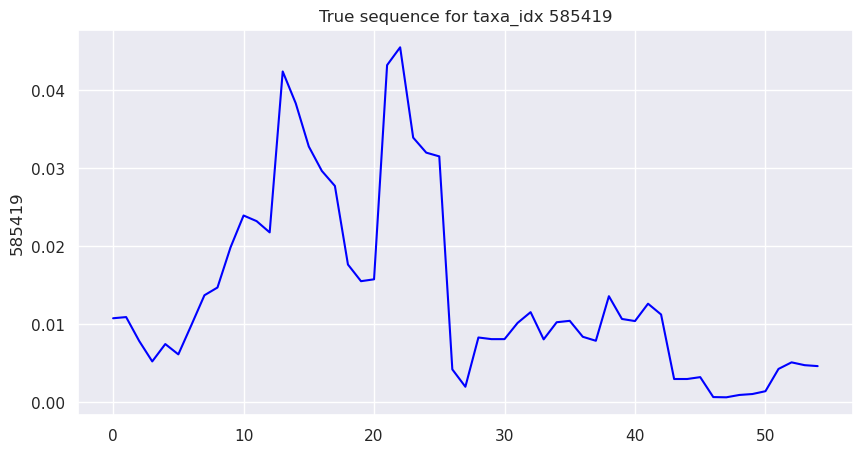

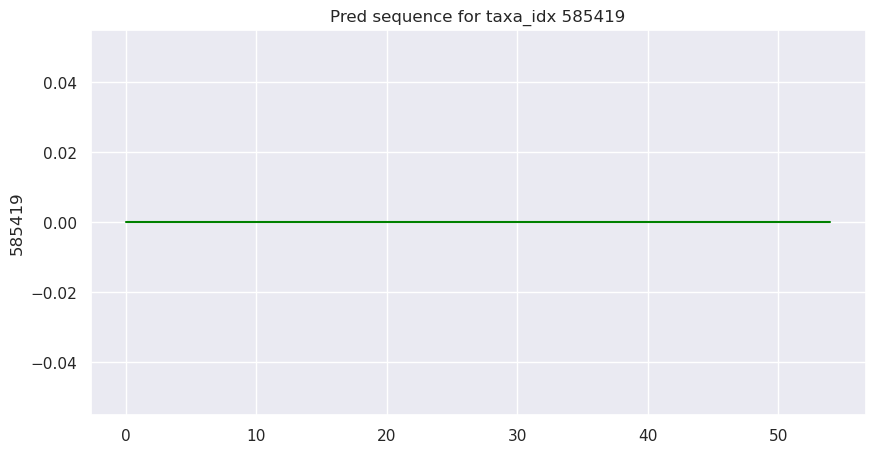

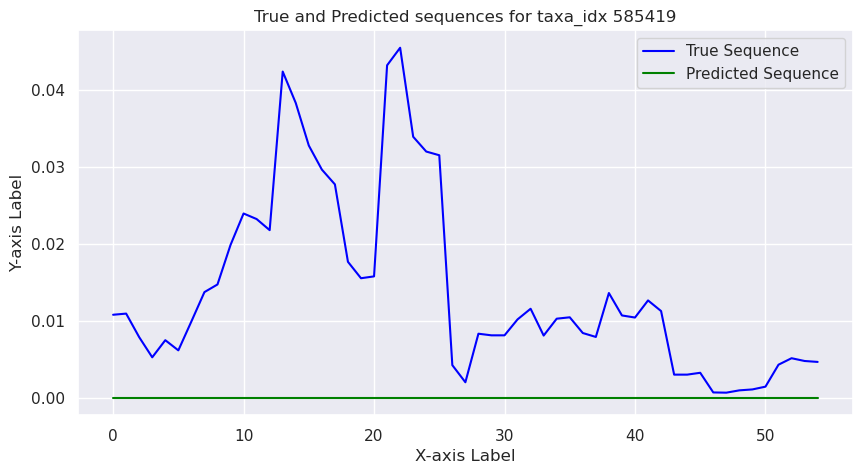

In [35]:
target_taxa = 585419

true_sequence = y_test_df[target_taxa].reset_index(drop=True)
pred_sequence = y_pred_df[target_taxa]

sequence_comparisson_graphs(true_sequence, pred_sequence, target_taxa)

In [36]:
def calculate_percentage_errors(y_pred_df, y_test_df):
    # Description: calculate percentage errors on on all taxa

    y_pred_df = y_pred_df.reset_index(drop=True)
    y_test_df = y_test_df.reset_index(drop=True)

    errors_df = []
    for col in y_pred_df.columns:
        errors = abs((y_pred_df[col] - y_test_df[col]) / (y_pred_df[col] + 1e-10))
        errors_df.append(errors)

    errors_df = pd.concat(errors_df, axis=1)

    return errors_df

In [37]:
errors_df = calculate_percentage_errors(y_pred_df, y_test_df)
errors_df.describe()

,659361,364179,3439402,181155,302746,4473763,175535,3887769,585227,189384,...,359650,130663,922761,3304236,584137,193233,4334711,196664,583117,354850
count,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,...,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000
mean,218900245.764851,2249847427.535937,0.443627,119356240.250703,704449818.466574,837108273.030666,1825022477.883562,2310743770.801155,263159209.438170,0.525334,...,2479756751.705578,670163161.215532,146857355.239571,1907235596.057009,517579351.481066,2251894491.899253,959198269.226258,1855818266.767678,1719474382.497677,2679552969.358531
std,314236370.956718,2965623042.675204,0.299207,83268344.397100,536075165.702982,847480332.159651,2293944648.700401,1825464423.288858,1329396806.936843,0.312340,...,1955578473.658811,605599701.109030,327750640.572671,1327383963.743113,424151646.516404,2188510203.863614,804186916.101823,1506411807.263208,1561095784.211890,2165481921.747774
min,0.000000,40543762.873899,0.003413,9569377.862666,63113603.645422,0.000000,0.000000,0.000000,0.000000,0.028307,...,0.000000,0.000000,0.010840,0.000000,223358.867715,0.000000,0.000000,2414001.174770,226336.514112,0.000000
25%,4559270.455845,160386356.074687,0.237290,57416267.175994,217391301.445341,221843000.451048,346534648.838613,727272717.562595,0.803554,0.304657,...,770799337.180177,224358971.363461,0.945256,918367334.677256,141497842.697699,776684086.831017,452755899.466872,875075425.854209,815603628.601719,697674409.289699
50%,12158054.548919,1148512812.167328,0.424154,95693778.626657,624123413.826946,716723539.918769,693069297.677226,2363636332.078434,1.354264,0.473138,...,2210440427.257439,512820505.973625,2167264.642242,1836734669.354513,452078348.255947,1268840339.872452,708661407.861190,1285455625.565148,1450590718.942255,2425249137.054667
75%,405775070.570164,2916510471.775547,0.623158,153110045.802652,1118513309.049416,1126279848.443780,3851485097.092010,3545454498.117651,5.890546,0.719889,...,3968189180.297949,993589730.323898,41418835.385064,2653061189.067630,784771381.718019,3638880295.925118,1377952737.507870,2936632429.107986,2064981186.498622,3803986660.174786
max,948328254.815663,9999999866.485682,1.000000,368421047.712630,1830294505.717225,4744027240.414709,8435643451.728517,7090908996.235302,8741412359.244562,1.229753,...,7120717686.331159,2435897403.374717,1731403641.968648,4897959118.278701,1445355232.986282,7860658154.046189,3346456648.233398,6572118198.311954,7504187125.375329,7674418502.186687


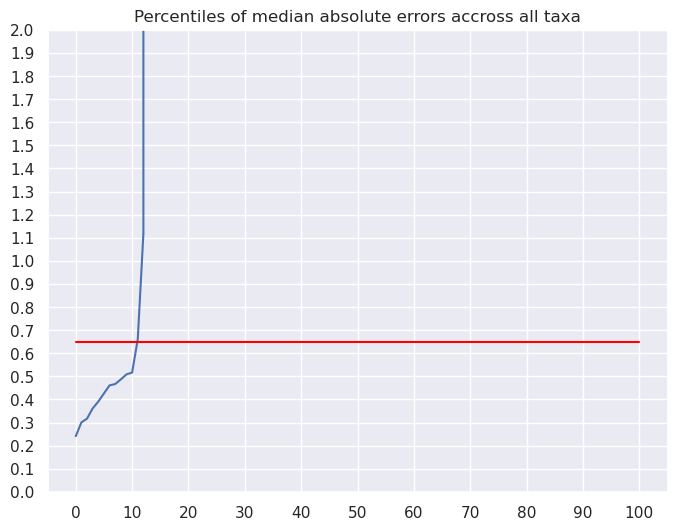

In [38]:
percentile_graph(errors_df, "accross all taxa", y_top_lim=2, x_percentile=0.65)

In [39]:
only_predicted_errors = errors_df[errors_df.columns[~(errors_df.columns.isin(non_predicted_cols))]]
only_predicted_errors.describe()

,3439402,585227,189384,570507,509416,192983,3014078,270094,1919007,529873,...,589277,180462,191483,178238,2415144,3426658,1078207,301578,366794,922761
count,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,...,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000
mean,0.443627,263159209.438170,0.525334,0.778474,0.891826,0.432976,0.689771,0.522854,0.410658,0.637430,...,0.346096,0.550608,0.449453,0.552992,0.404324,0.507513,0.811679,0.457154,7442850.181576,146857355.239571
std,0.299207,1329396806.936843,0.312340,0.605554,1.832904,0.337497,0.733062,0.392613,0.282805,0.710477,...,0.267382,0.319863,0.385878,0.237700,0.267946,0.362816,0.720799,0.324903,42192028.187040,327750640.572671
min,0.003413,0.000000,0.028307,0.001684,0.006474,0.000800,0.007895,0.009422,0.008655,0.003504,...,0.024587,0.007133,0.007781,0.019508,0.007561,0.017352,0.012221,0.007564,0.013892,0.010840
25%,0.237290,0.803554,0.304657,0.369776,0.259897,0.165485,0.176004,0.213754,0.246223,0.211842,...,0.171058,0.328883,0.130524,0.398974,0.183563,0.246518,0.472064,0.210935,0.176525,0.945256
50%,0.424154,1.354264,0.473138,0.750969,0.510266,0.307534,0.489859,0.459855,0.356707,0.508631,...,0.300472,0.465928,0.316079,0.569404,0.375825,0.422060,0.648616,0.360385,0.389195,2167264.642242
75%,0.623158,5.890546,0.719889,0.934210,0.632345,0.704188,0.939626,0.781923,0.534862,0.761981,...,0.449825,0.846949,0.669888,0.754832,0.572471,0.734461,0.885866,0.678157,0.791837,41418835.385064
max,1.000000,8741412359.244562,1.229753,3.448766,12.478133,1.176139,3.467370,1.951812,1.038720,4.452980,...,0.999123,1.399037,1.539558,0.928461,1.000000,1.588608,4.189272,1.079398,292397656.914786,1731403641.968648


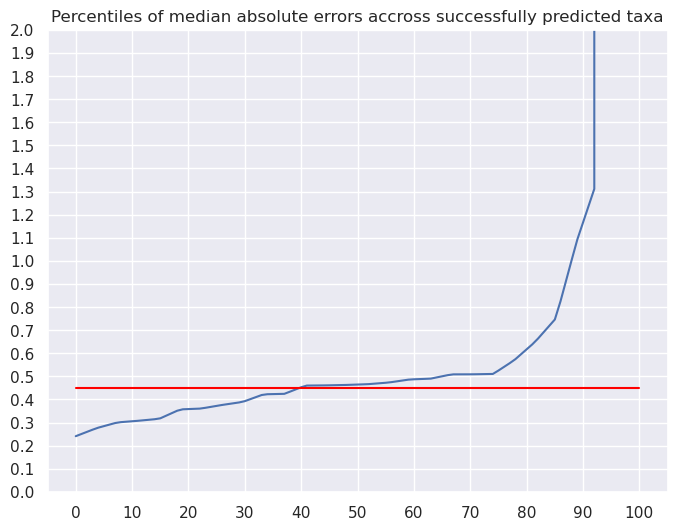

In [40]:
percentile_graph(only_predicted_errors, "accross successfully predicted taxa", y_top_lim=2, x_percentile=0.45)